<a href="https://colab.research.google.com/github/Carlos-Muniz/Boston-Housing-Regression/blob/master/Superconductivity_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boston Housing Regression

* Problem:
* Dataset: [UCI ML Superconducitivy Data](https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data)
* Approach:
* Models:


## Overview
1. Import Libraries
2. Load Data
3. Data Analysis
4. Model Classes
5. Training
6. Evaluation
7. Model Comparison
8. Conclusion



# Import Libaries

In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=a15e125f4825487b7235b31319c075a78c44ef534353e86e2a94b8307412816c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch import optim
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt
import wget
import os
import zipfile

# Load Data


In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00464/superconduct.zip"
filename = wget.download(url)

In [11]:
with zipfile.ZipFile(filename, 'r') as zipf:
    with zipf.open('train.csv', 'r') as fin:
        data = pd.read_csv(fin)

In [41]:
data.describe

<bound method NDFrame.describe of        number_of_elements  mean_atomic_mass  ...  wtd_std_Valence  critical_temp
0                       4         88.944468  ...         0.437059          29.00
1                       5         92.729214  ...         0.468606          26.00
2                       4         88.944468  ...         0.444697          19.00
3                       4         88.944468  ...         0.440952          22.00
4                       4         88.944468  ...         0.428809          23.00
...                   ...               ...  ...              ...            ...
21258                   4        106.957877  ...         0.496904           2.44
21259                   5         92.266740  ...         0.212959         122.10
21260                   2         99.663190  ...         0.400000           1.98
21261                   2         99.663190  ...         0.462493           1.84
21262                   3         87.468333  ...         1.500000          

# Data Analysis

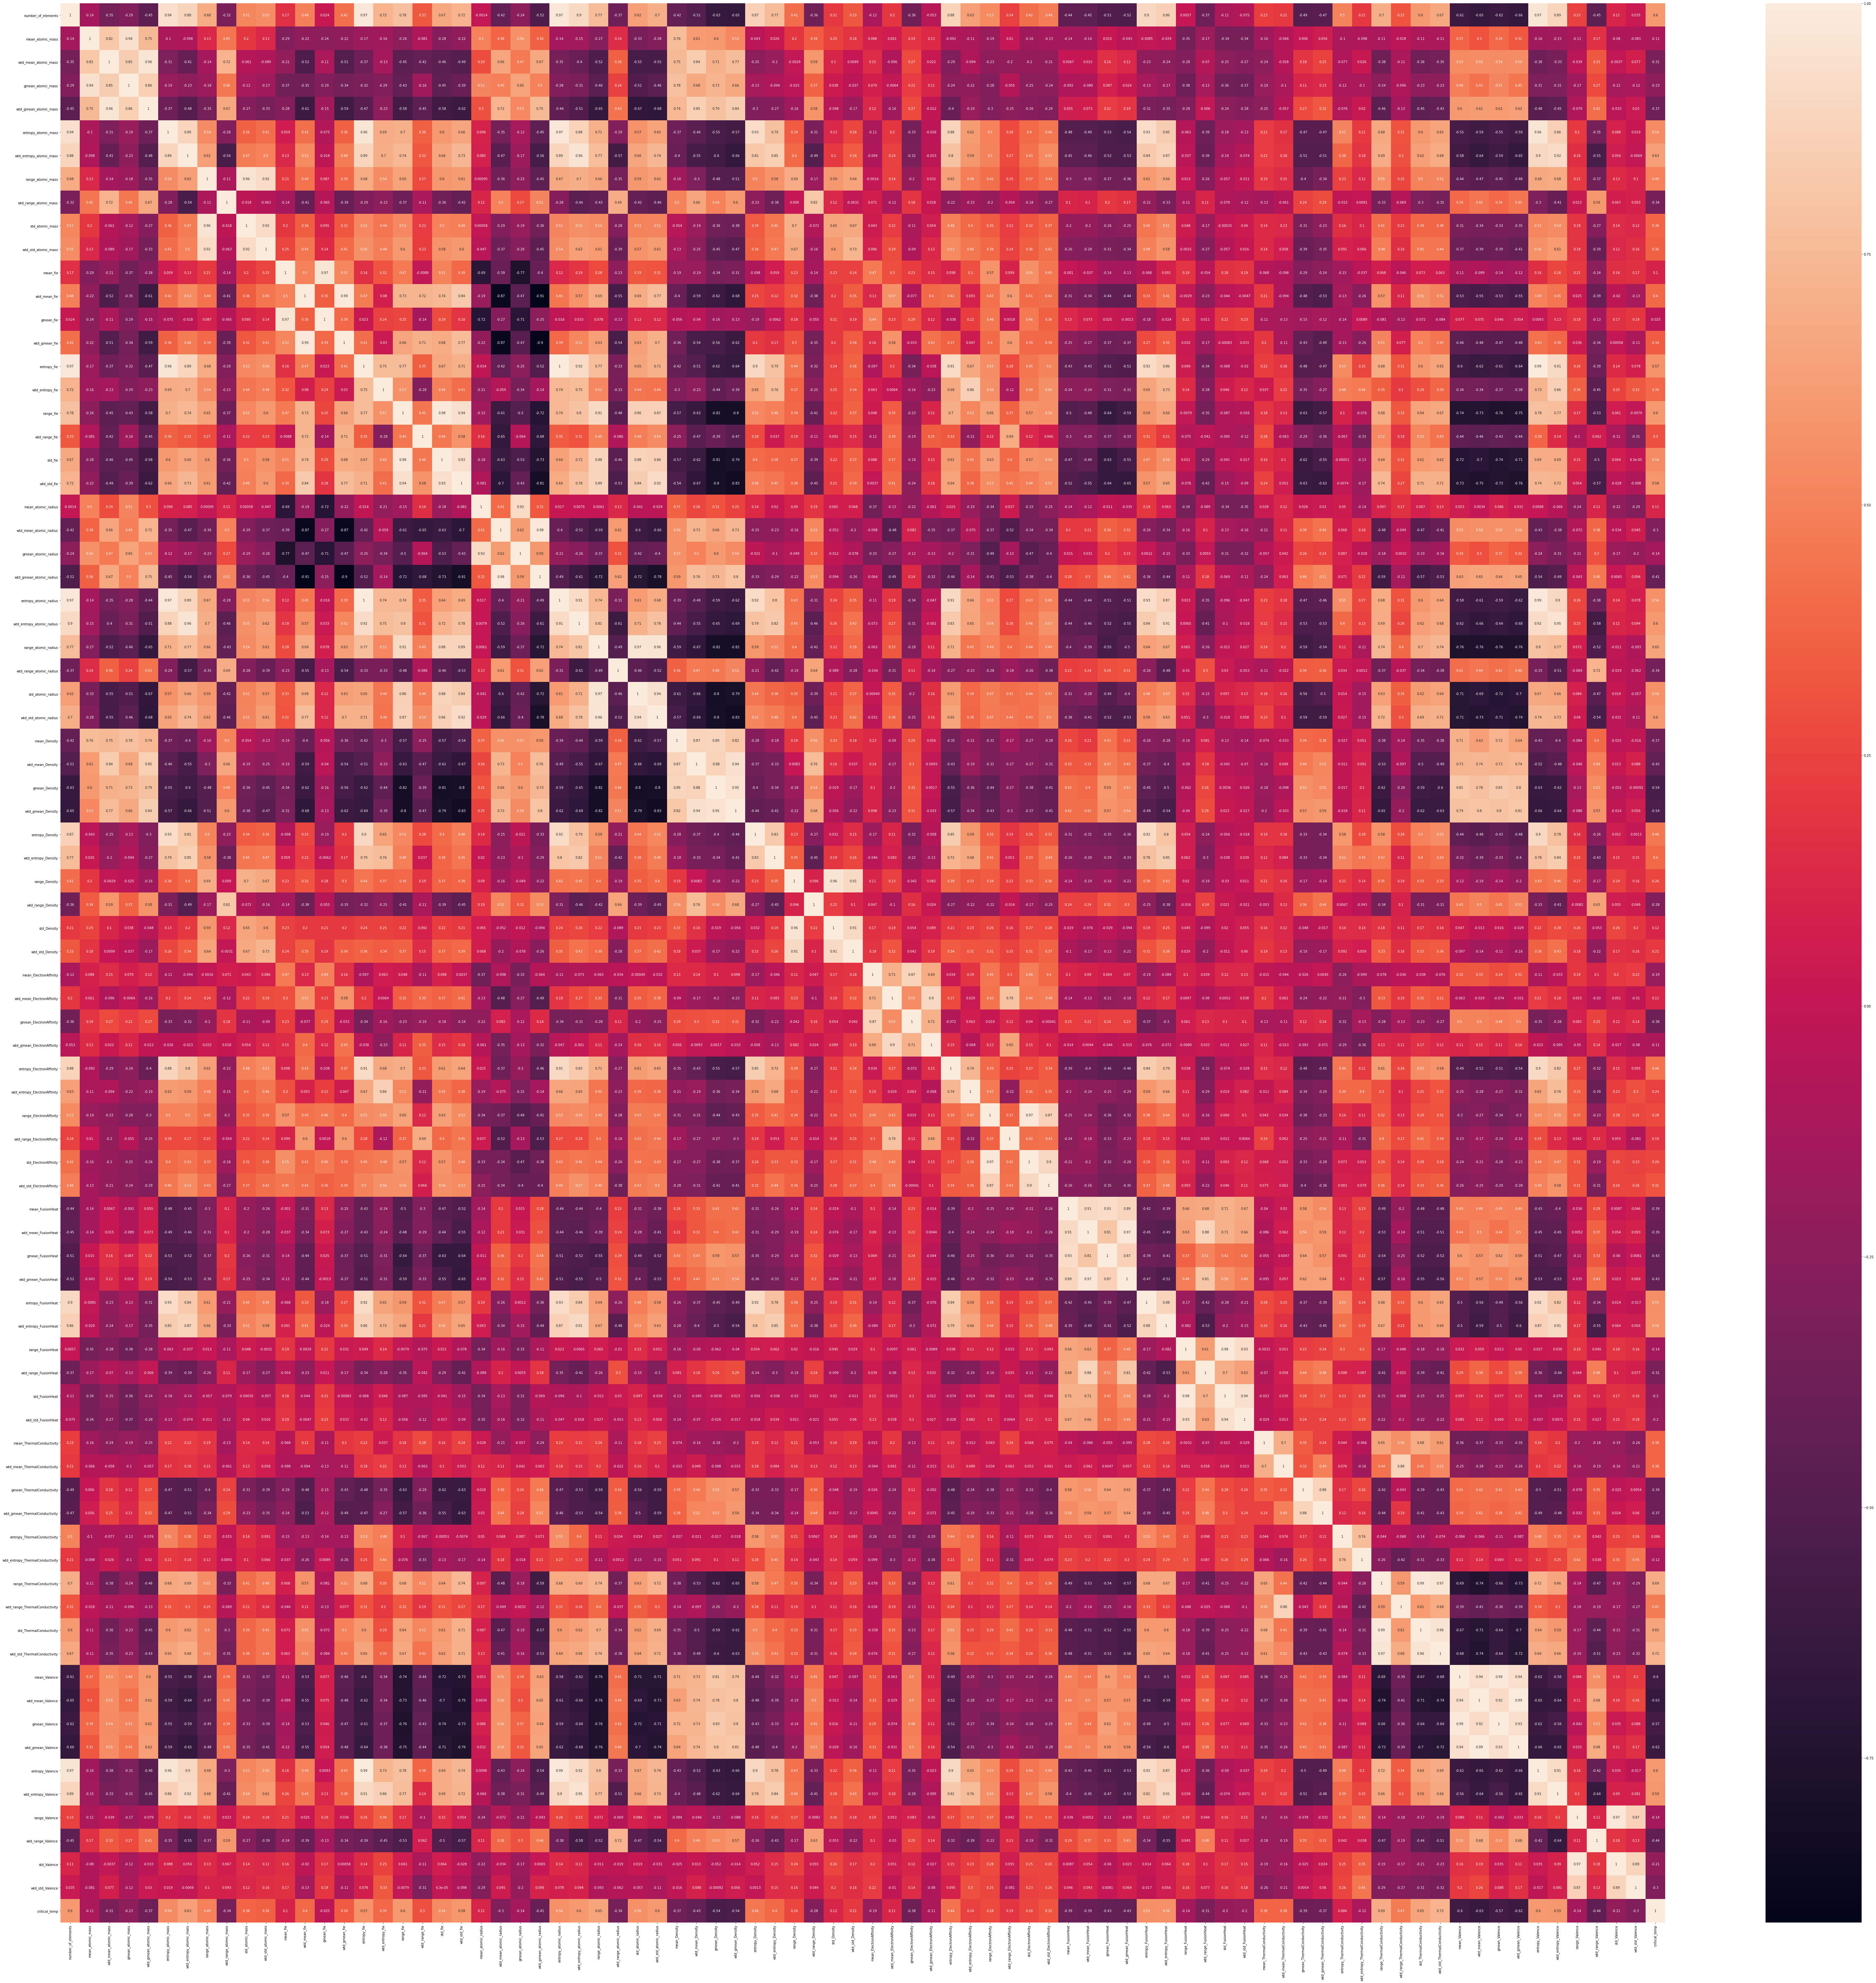

In [20]:
plt.figure(figsize=(110,108))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)

In [39]:
corr_matrix['critical_temp'].apply(abs).sort_values().tail(11)

range_fie                      0.600790
number_of_elements             0.601069
wtd_entropy_atomic_radius      0.603494
wtd_gmean_Valence              0.615653
wtd_entropy_atomic_mass        0.626930
wtd_mean_Valence               0.632401
std_ThermalConductivity        0.653632
range_atomic_radius            0.653759
range_ThermalConductivity      0.687654
wtd_std_ThermalConductivity    0.721271
critical_temp                  1.000000
Name: critical_temp, dtype: float64

We will be predicting **critical_temp**. 

There are 81 predictors. The Correlation table is diverse and just from the spectrum of colors, one could say there is plenty of promise from the correlation.

Below the Heatmap, there is sorted list of the absolute correlation coefficients. This gives us the top 10 most correlated (postive and negative) predictors.

From these top predictors we can see that Thermal Conductivity, Valence, and Atomic Size are three of the most important predictor topics. This is backed up by the Van der Waals Equation of State for real gases.

(P + a/(V^2))*(V-b) = RT

P is pressure, V is volume, T is temperature, and R is the gas constant. a and b are Van der Waals constants where a is the attraction between the molecules, and b is the volume of a single molecule,

Van der Waal's constant a is highly dependent on Conductivity and Valence Electrons. And constant b is dependent on Atomic Size.

# Model Classes

## Data Class

In [70]:
class DataMaker(Data.Dataset):
    def __init__(self, X, y):
        scaler = StandardScaler()
        # scaler = MinMaxScaler()
        self.targets = scaler.fit_transform(X.astype(np.float32))
        self.labels = y.astype(np.float32)
    
    def __getitem__(self, i):
        return self.targets[i, :], self.labels[i]

    def __len__(self):
        return len(self.targets)

In [71]:
cols = data.columns
X, y = data[cols[:-1]].values, data[cols[-1]].values
n_samples, n_features = X.shape
X = X.astype(np.float32)
y = y.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape

(15947, 81)

In [72]:
train_set = DataMaker(X_train, y_train)
test_set = DataMaker(X_test, y_test)

In [73]:
bs = 431
train_loader = Data.DataLoader(train_set, batch_size=bs, shuffle=True)
test_loader = Data.DataLoader(test_set, batch_size=bs, shuffle=True)

## Neural Network Class

In [74]:
class Model(nn.Module):
    def __init__(self, n_features, hiddenA, hiddenB):
        super(Model, self).__init__()
        self.linearA = nn.Linear(n_features, hiddenA)
        self.linearB = nn.Linear(hiddenA, hiddenB)
        self.linearC = nn.Linear(hiddenB, 1)

    def forward(self, x):
        yA = F.relu(self.linearA(x))
        yB = F.relu(self.linearB(yA))
        return self.linearC(yB)

In [75]:
torch.manual_seed(1)

In [88]:
net = Model(n_features, 400, 200)

In [89]:
criterion = nn.MSELoss(size_average=False)
optimizer = optim.Adam(net.parameters(), lr=0.01)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Training

In [90]:
n_epochs = 300
all_losses = []
for epoch in range(n_epochs):
    progress_bar = tqdm.notebook.tqdm(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        optimizer.zero_grad()
        y_pred = net(inputs)
        loss = criterion(y_pred, torch.unsqueeze(target,dim=1))

        loss.backward()
        
        optimizer.step()
        
        progress_bar.set_description(
            f'Epoch #{epoch+1}\tLoss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1

    epoch_loss = sum(losses) / total
    all_losses.append(epoch_loss)
                
    mess = f"Epoch #{epoch+1}\tLoss: {all_losses[-1]:.3f}"
    if (epoch+1) % 20 == 0:
        tqdm.tqdm.write(mess)

Epoch #20	Loss: 64227.410


Epoch #40	Loss: 51086.125


Epoch #60	Loss: 46387.177


Epoch #80	Loss: 44257.456


Epoch #100	Loss: 40522.334


Epoch #120	Loss: 36764.538


Epoch #140	Loss: 36965.935


Epoch #160	Loss: 32324.294


Epoch #180	Loss: 32035.982


Epoch #200	Loss: 31400.610


Epoch #220	Loss: 29486.694


Epoch #240	Loss: 28512.912


Epoch #260	Loss: 28793.413


Epoch #280	Loss: 28018.830


Epoch #300	Loss: 26563.687


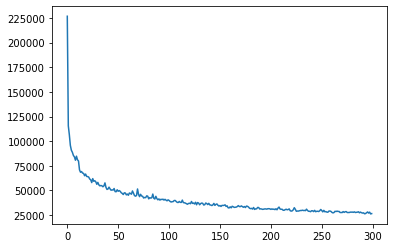

In [91]:
plt.plot(all_losses)

## Evaluation

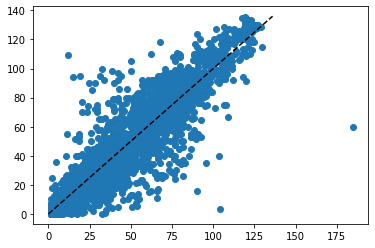

In [94]:
y_pred = []
y_true = []
net.train(False)
for inputs, targets in test_loader:
    y_pred.extend(net(inputs).data.numpy())
    y_true.extend(targets.numpy())
plt.scatter(y_pred, y_true)
y_min, y_max = np.floor(np.min(y_true)), np.ceil(np.max(y_true))
plt.plot([y_min, y_max], [y_min, y_max], '--k')

In [95]:
print("MAE:", mean_absolute_error(y_true, y_pred))
print("MSE:", mean_squared_error(y_true, y_pred))
print("R^2:", r2_score(y_true, y_pred))

MAE: 6.343993
MSE: 114.9929
R^2: 0.8999501535120499


# Model Comparison

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge

dataset = [X_train, X_test, y_train, y_test]

def model_train_test(model, dataset):
    X_train, X_test, y_train, y_test = dataset
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.scatter(y_pred, y_test)
    y_min, y_max = np.floor(np.min(y_true)), np.ceil(np.max(y_true))
    plt.plot([y_min, y_max], [y_min, y_max], '--k')
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R^2:", r2_score(y_test, y_pred))

Linear Regression:
MAE: 13.585032
MSE: 318.60693
R^2: 0.7227952806390601


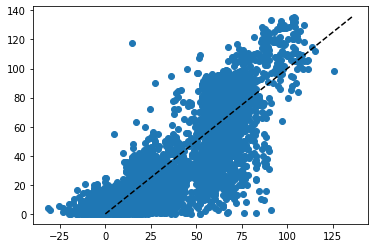

In [108]:
linreg = LinearRegression()
print("Linear Regression:")
model_train_test(linreg, dataset)

Elastic Net Regression:


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2192590.25, tolerance: 1883.78515625
  positive)


MAE: 13.985276
MSE: 337.56573
R^2: 0.7063001515165166


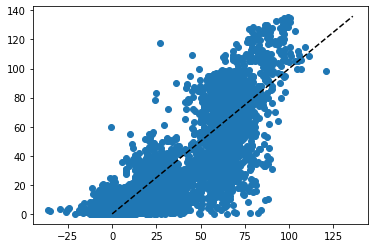

In [110]:
elastic_net = ElasticNet()
print("Elastic Net Regression:")
model_train_test(elastic_net, dataset)

Bayesian Ridge Regression:
MAE: 13.535700547038138
MSE: 317.79615895143417
R^2: 0.7235007166992644


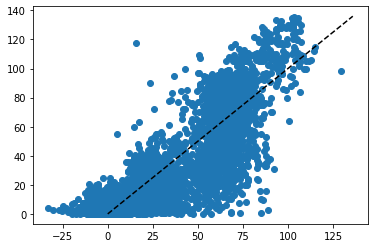

In [109]:
bayes_ridge = BayesianRidge()
print("Bayesian Ridge Regression:")
model_train_test(bayes_ridge, dataset)

# Conclusion

We can make an incomplete conclusion that the pytorch model is a better predictor than this selection of out of the box Sklearn models, with built-in Cross validation.

This does not mean that Neural Networks are the best way to solve this problem. In order to conclude that, we would have to compare many different ML models, and also perform tuning the Neural Network's hyperparameters.